In [1]:
import sys
print(sys.executable)
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy

from pinn import PINNs
# from  import PINNsformer
from pyhessian import hessian
from utils import get_data

dev = torch.device('cpu')

/home/mukul/miniconda3/envs/PF/bin/python


/home/mukul/miniconda3/envs/PF/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
N_x = 101
N_t = 101

In [4]:
model = PINNs(in_dim=2, hidden_dim=256, out_dim=1, num_layer=6)
state = torch.load('BS_Put_PINNs_101', map_location=torch.device('cpu'))
model.load_state_dict(state)

res, b_left, b_right, b_upper, b_lower = get_data([0,10], [0, 1], N_x, N_t)

print('load done')

TypeError: Expected state_dict to be dict-like, got <class 'loss_landscape_anim.model.MLP'>.

In [8]:
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(dev)

In [9]:
# TODO: Compute hessian

hessian = hessian(model=model, data=(res[:,0:1], res[:,1:2]))
print('hessian done')
ev, evec = hessian.eigenvalues(top_n=2)

/home/mukul/miniconda3/envs/PF/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/torch/csrc/autograd/engine.cpp:1203.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


hessian done


In [11]:
# TODO: Perturbation range
pev1 = np.linspace(-0.1, 0.1, 101)
pev2 = np.linspace(-0.1, 0.1, 101)

In [12]:
pev1_mesh, pev2_mesh = np.meshgrid(pev1,pev2)
pmat = np.concatenate((np.expand_dims(pev1_mesh, -1), np.expand_dims(pev2_mesh, -1)), axis=-1).reshape(-1,2)

print(ev[0], ev[1])

130552.6015625 -63624.703125


In [13]:
x_res, t_res = res[:,0:1], res[:,1:2]

In [14]:
loss_track = []

for pev in tqdm(pmat):
    pev1, pev2 = pev[0], pev[1]

    # TODO: Reload the model
    # model = PINNs(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4)
    # model.load_state_dict(torch.load('./trans_wave/reaction_diffusion_trans_model.pkl', map_location=torch.device('cpu')))
    state_dict = state['state_dict']

    # Compute model params with perturbation
    for i,key in enumerate(state_dict.keys()):
        state_dict[key] = state_dict[key] + pev1*evec[0][i] + pev2*evec[1][i]
    model.load_state_dict(state_dict)

    # Compute the PINNs loss
    pred_res = model(x_res, t_res)
    u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    loss_res = torch.mean(u_x ** 2)
    
    loss_track.append(loss_res.item())

100%|██████████| 10201/10201 [02:35<00:00, 65.68it/s]


In [15]:
loss_track = np.array(loss_track).reshape(101,101)

In [16]:
np.save('pinns_loss_landspace.npy', loss_track)

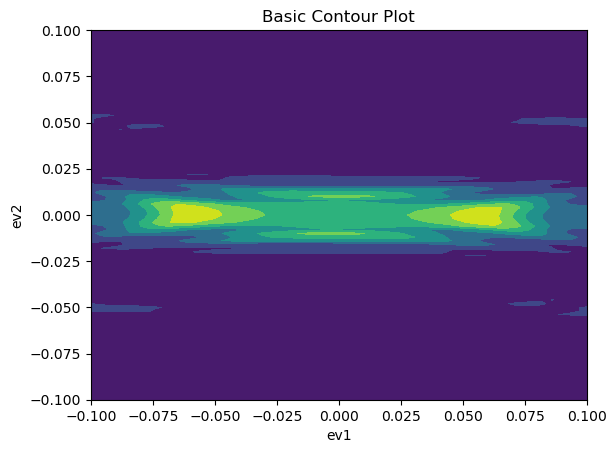

In [34]:
plt.contourf(pev1_mesh, pev2_mesh, loss_track)
# Adding labels and title
plt.xlabel('ev1')
plt.ylabel('ev2')
# plt.zlabel('loss')
plt.title('Basic Contour Plot')

# Displaying the plot
plt.show()

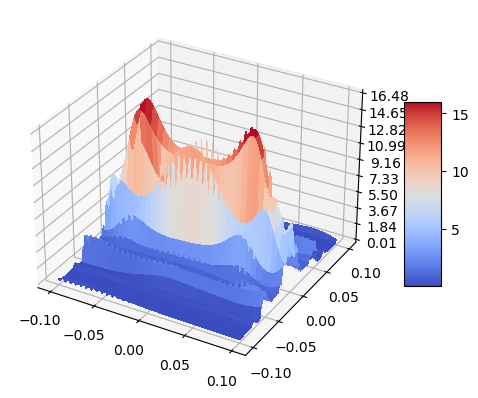

In [35]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(pev1_mesh, pev2_mesh, loss_track, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

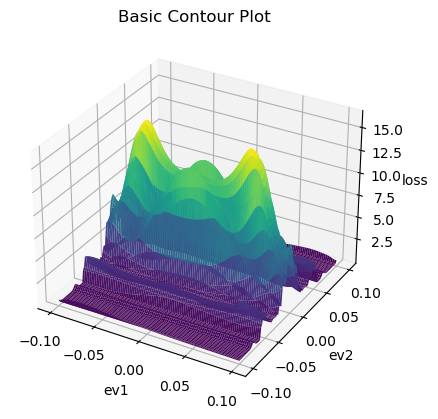

In [72]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(pev1_mesh, pev2_mesh, loss_track, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
plt.xlabel('ev1')
plt.ylabel('ev2')
ax.set_zlabel("loss")
plt.title('Basic Contour Plot')

# Displaying the plot
plt.show()

In [2]:
import loss_landscape_anim

/home/mukul/miniconda3/envs/PF/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
loss_landscape_anim.loss_landscape_anim(n_epochs=100, model=model, model_dirpath='./', model_filename='BS_Put_PINNs_101')

NameError: name 'model' is not defined